In [1]:
from __future__ import annotations

from collections.abc import Iterable
from typing import Any

import polars as pl
from anndata import AnnData
from lets_plot import (
    LetsPlot,
    aes,
    element_blank,
    element_rect,
    element_text,
    geom_point,
    ggplot,
    ggsize,
    ggtb,
    guide_legend,
    guides,
    layer_tooltips,
    scale_fill_gradient,
    scale_size,
    scale_x_discrete,
    scale_y_discrete,
    theme,
    theme_classic,
    coord_flip,
)
from lets_plot.plot.core import PlotSpec

from cellestial.util import _decide_tooltips, _range_inclusive


def _construct_dotplot_frame(
    df: pl.DataFrame,
    group_by: str,
    *,
    add_mean: bool = True,
    add_percentage: bool = True,
    add_sum: bool = True,
    variable_name: str = "gene",
    value_name: str = "expression",
    threshold: float = 0,
) -> pl.DataFrame:
    if add_sum:
        df_sum = (
            df.group_by(group_by)
            .sum()
            .unpivot(index=group_by, variable_name=variable_name, value_name=f"sum_{value_name}")
        )
    if add_mean:
        df_mean = (
            df.group_by(group_by)
            .mean()
            .unpivot(index=group_by, variable_name=variable_name, value_name=f"mean_{value_name}")
        )
    if add_percentage:
        df_percentage = (
            df.group_by(group_by)
            .agg(
                (
                    pl.all().exclude(group_by).gt(threshold).sum()
                    / pl.all().exclude(group_by).count()
                ).mul(100)
            )
            .unpivot(index=group_by, variable_name=variable_name, value_name="cell_percentage")
        )

    frame = df_sum.join(df_mean, on=[group_by, variable_name]).join(
        df_percentage, on=[group_by, variable_name]
    )

    # frame = frame.with_columns(pl.selectors.numeric().replace(0,None))

    return frame


def _make_dotplot(
    frame_dotplot,
    group_by,
    *,
    tooltips: list[str] | None = None,
    fraction_name: str = "cell_percentage",
    mean_name: str = "mean_expression",
    color_low: str = "#e6e6e6",
    color_high: str = "#D2042D",
    n_legend: int = 5,
    **dotplot_kwargs,
) -> PlotSpec:
    # create a stop points for the legend of the mean expression
    pct_min = frame_dotplot.select(fraction_name).min().item()
    pct_max = frame_dotplot.select(fraction_name).max().item()
    pct_lims = _range_inclusive(pct_min, pct_max, n_legend)
    # create a stop points for the legend of the mean expression
    mean_min = frame_dotplot.select(mean_name).min().item()
    mean_max = frame_dotplot.select(mean_name).max().item()
    mean_lims = _range_inclusive(mean_min, mean_max, n_legend)
    # defaults for the dotplot
    all_kwargs = {"shape": 21, "color": "#1f1f1f", "stroke": 0.2}
    if dotplot_kwargs:
        all_kwargs.update(dotplot_kwargs)

    frame_dotplot = frame_dotplot.sort([group_by, mean_name], descending=True)
    dtplt = (
        ggplot(frame_dotplot)
        + geom_point(
            aes(x="gene", y=group_by, fill=mean_name, size=fraction_name),
            tooltips=layer_tooltips(tooltips),
            show_nan=True,
            **all_kwargs,
        )
        + scale_fill_gradient(low=color_low, high=color_high, breaks=mean_lims)
        # THEME FOR THE DOTPLOT
        + theme_classic()
        + theme(
            panel_border=element_rect(color="#1f1f1f", size=1.5),
            text=element_text(family="Arial", color="#1f1f1f"),
            axis_text_x=element_text(angle=90),
            axis_title=element_blank(),
            legend_text=element_text(size=10),
            legend_title=element_text(size=12),
            legend_box_spacing=0,
            legend_key_spacing_y=0,
        )
        #+ ggsize(400, 600)
        + guides(size=guide_legend(ncol=1))
        + scale_size(breaks=pct_lims, range=[1, 10])
        + scale_y_discrete(expand=[0.05, 0.05])
        + scale_x_discrete(expand=[0.05, 0.05])
    )

    return dtplt


def dotplot(
    data: AnnData,
    keys: str | list[str] | Iterable[str],
    group_by: str,
    *,
    color_low: str = "#e6e6e6",
    color_high: str = "#D2042D",
    threshold: float | None = None,
    use_raw: bool = True,
    show_tooltips: bool = True,
    add_tooltips: list[str] | tuple[str] | Iterable[str] | None = None,
    custom_tooltips: list[str] | tuple[str] | Iterable[str] | None = None,
    n_legend: int = 5,
    interactive: bool = False,
    **dotplot_kwargs: dict[str, Any],
) -> PlotSpec:
    # Handling Data types
    if not isinstance(data, AnnData):
        msg = "data must be an `AnnData` object"
        raise TypeError(msg)
    if not isinstance(keys, Iterable) and not isinstance(keys, str):
        msg = "keys must be an iterable or a string"
        raise TypeError(msg)
    elif isinstance(keys, str):
        keys = [keys]
    if not isinstance(group_by, str):
        msg = "group_by must be a string"
        raise TypeError(msg)

    else:
        if "tooltips" in dotplot_kwargs:
            msg = "use tooltips args within the function instead of adding `'tooltips' : 'value'` to `dotplot_kwargs`\n"
            raise KeyError(msg)

    # handle tooltips
    base = ["cell_percentage", "mean_expression"]
    tooltips = _decide_tooltips(
        base_tooltips=["cell_percentage", "mean_expression"],
        add_tooltips=add_tooltips,
        custom_tooltips=custom_tooltips,
        show_tooltips=show_tooltips,
    )

    if use_raw: # TO BE CHANGED (to layer)
        matrix = data.raw.X.toarray()
        if threshold is None:
            threshold = 0
    else:
        matrix = data.X
        if threshold is None:
            threshold = -10

    # gene indexes for the AnnData.X
    gene_indexes = data.var_names.get_indexer(keys)
    frame = pl.from_numpy(matrix[:, gene_indexes], schema=keys)
    frame = frame.with_columns(pl.Series(group_by, data.obs[group_by]))

    # create the dataframe for the dotplot
    frame_dotplot = _construct_dotplot_frame(frame, group_by)
    frame_dotplot = frame_dotplot.with_columns(pl.col(base).replace(0, None))
    print(frame_dotplot)
    # create the dotplot
    dtplt = _make_dotplot(
        frame_dotplot,
        group_by,
        color_low=color_low,
        color_high=color_high,
        n_legend=n_legend,
        tooltips=tooltips,
        **dotplot_kwargs,
    )

    if interactive:
        dtplt += ggtb()

    return dtplt





In [2]:
import scanpy as sc

LetsPlot.setup_html()
data = sc.read("data/pbmc3k_pped.h5ad")
keys = data.var_names[-10:].tolist()
group_by = "leiden"
gene_indexes = data.var_names.get_indexer(keys)
dp = dotplot(data, keys, group_by, use_raw=True, stroke=0.5)


shape: (200, 5)
┌────────┬────────────┬────────────────┬─────────────────┬─────────────────┐
│ leiden ┆ gene       ┆ sum_expression ┆ mean_expression ┆ cell_percentage │
│ ---    ┆ ---        ┆ ---            ┆ ---             ┆ ---             │
│ cat    ┆ str        ┆ f32            ┆ f32             ┆ f64             │
╞════════╪════════════╪════════════════╪═════════════════╪═════════════════╡
│ 0      ┆ AC244090.3 ┆ 1.0            ┆ 0.000348        ┆ 0.034795        │
│ 12     ┆ AC244090.3 ┆ 1.0            ┆ 0.002421        ┆ 0.242131        │
│ 3      ┆ AC244090.3 ┆ 0.0            ┆ null            ┆ null            │
│ 14     ┆ AC244090.3 ┆ 0.0            ┆ null            ┆ null            │
│ 1      ┆ AC244090.3 ┆ 0.0            ┆ null            ┆ null            │
│ …      ┆ …          ┆ …              ┆ …               ┆ …               │
│ 15     ┆ MT-ND5     ┆ 0.0            ┆ null            ┆ null            │
│ 4      ┆ MT-ND5     ┆ 0.0            ┆ null            ┆ n

In [3]:
dp + ggsize(400, 600)

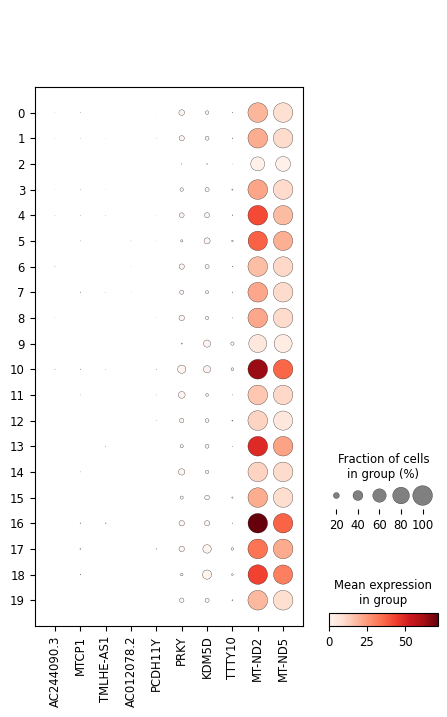

In [4]:
sc.pl.dotplot(data, keys, group_by)